### Testing the impact of resolution versus model physics in Polar-WRF experiments 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In order to test the impact of resolution versus model physics in the WRF downscalling, we coarsegrain the WRF-10km forcing to 80 km resolution. Note that coarsegraining keeps the WRF-10km on the same grid but takes an average over the surrounding 64 (8x8) squares as the value for each point. This method conserves the improved physics associated the higher resolution.     

Despite the coarser resolution, strong gradients in winds are preserved, which is important for the location and propagation of leads. Consequently, the simulated break-up is very similar to the standard WRF-10km.  


In [1]:
%matplotlib inline
import numpy as np
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from pathlib import Path  
import sys
import xarray as xr
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs
import pyproj
import matplotlib.gridspec as gridspec
import cmocean
import argparse
import locale 
import matplotlib.ticker as mticker

from pynextsim.projection_info import ProjectionInfo

In [5]:
def get_transect(xr, start_time, end_time, xpoint, ypoint):

    time_slice = slice(start_time, end_time)
    x_slice = xpoint[0]
    y_slice = slice(ypoint[0], ypoint[1])

    transect = xr.sel(time=time_slice, x=x_slice, y=y_slice)

    # make array of datetime objects
    vtimes = transect.time.values.astype('datetime64[ms]').astype('O')

    # Specify y values for transect
    length = y_slice.stop - y_slice.start
    res = 5 # 5 km grid spacing
    ydist = np.arange(0,length*res, res) # distance in km from Banks Island (y0)

    return ydist, vtimes, transect

def plot_map(ax):

    lons = ds.longitude[:] #dims:y,x
    lats = ds.latitude[:]

    # find lon,lat coordinates for x,y points
    lon0 = lons[ypoint[0]][xpoint[0]]
    lon1 = lons[ypoint[1]][xpoint[1]]
    lat0 = lats[ypoint[0]][xpoint[0]]
    lat1 = lats[ypoint[1]][xpoint[1]]
    lon = (lon0, lon1)
    lat = (lat0, lat1)
    
    proj = ccrs.NorthPolarStereo(central_longitude=-45)
    ax.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], crs=ax.projection) 

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1) 
    ax.coastlines(resolution='50m', linewidth=0.5) 
    ax.gridlines(draw_labels=False, linestyle='dotted')
    ax.plot(lon, lat, 'ro-', transform=ccrs.Geodetic()) # geodetic plots shortest distance 
    ax.patch.set_alpha(0.5)

def plot_transect(ax, vname, outdir, moorings_file, add_insetmap=True):
    global clabel, figname, cmap, clim, cb_extend, zlev
    clabel, figname, cmap, clim, cb_extend, zlev = _PLOT_INFO[vname]
    
    print("Start plotting", vname)
    #fig = plt.figure(figsize=(8, 3))
    #fig.subplots_adjust(bottom=0.2, top=0.90, left=0.1, right=0.95, wspace=0.01, hspace=0.01)
    #ax = fig.add_subplot(111)
    
    if np.size(clim)==2: #contineous colormap 
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
        vmin=clim[0], vmax=clim[1], cmap=cmap, extend=cb_extend)
    else: #discrete colormap
        clevs = np.arange(clim[0], clim[1]+clim[2],clim[2])
        cf = ax.contourf(vtimes, yvals, transect.transpose(), 
            levels=clevs, cmap=cmap, extend=cb_extend)

    # add single contour line
    cline = ax.contour(vtimes, yvals, transect.transpose(), levels=zlev,  colors='k', linewidths=0.5)
    
    # add colorbar
   # cbar = plt.colorbar(cf, ax=ax, orientation='vertical', pad=0.02, aspect=40)
    #cbar.set_label(clabel)  
    pos = ax.get_position() 
    cax = fig.add_axes([pos.xmax+.015, pos.y0, 0.01, pos.ymax-pos.y0 ])
    cbar=fig.colorbar(cf,cax=cax)
    cbar.set_label(clabel)
    
    # set labels
#    locale.setlocale(locale.LC_ALL,'en_US')  # change language to EN
    days = mdates.DayLocator()  # every day
    dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
    ax.xaxis.set_major_formatter(dtFmt)
    ax.xaxis.set_minor_locator(days)
    #plt.xticks(rotation=45) # rotate xlabels
    ax.set_ylabel("y")

    # add map 
    if add_insetmap:
        proj = ccrs.NorthPolarStereo(central_longitude=-45)
        ax_inset = fig.add_axes([pos.x0-0.025, pos.y0+.01, 0.18, 0.4], projection=proj)
        plot_map(ax_inset) 

def prepare_grid(ds):
    extent = [-110, 200, 67, 90]
    proj = ProjectionInfo() # default nextsim projection

    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,)

    return grid

def make_figure(wi, hi, nrow, ncol):
   # ar = 0.9  # initial aspect ratio for first trial
   # wi = 8    # width in inches
   # hi = wi * ar  # height in inches

    fig = plt.figure(figsize=(wi,hi))
    plt.subplots_adjust(hspace=0.01, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 


In [26]:
# main

# create dictionary for plotting different variables
_PLOT_INFO =dict(
    wspeed = ('Wind speed (m s$^{-1}$)', 'wspeed_transect_beaufort','RdYlBu_r', [0,20,1], 'max', [10]),
    icevel = ('Ice velocity (cm s$^{-1}$)', 'icevel_transect_beaufort', cmocean.cm.speed, [0, 40, 2], 'max', [5]),    
)

rootdir = '/home/rheinlender/shared-simstore-ns9829k/'
datadir = rootdir + 'home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/'
outdir =  rootdir + 'home/rheinlender/figs/breakup-paper/'

expts = ["expt_01_wrf10/outputs/", 
         "expt_01_smoothed80/outputs/"]
expts_names = ["wrf10",  "wrf10_coarse80"]

files = [os.path.join(datadir, f, 'Moorings.nc') for f in expts]

# Create slice variables subset domain
vname=['wspeed', 'icevel']
start_time = '2013-02-11'
end_time = '2013-03-13'
xpoint = (100, 100)
ypoint = (180, 450)


## Plot the propagation of leads in the Beaufort Sea

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
Start plotting icevel
Saving /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/icevel_transect_beaufort_20130213-20130312_wrf10.png
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_smoothed80/outputs/Moorings.nc
Start plotting icevel
Saving /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/icevel_transect_beaufort_20130213-20130312_wrf10_coarse80.png


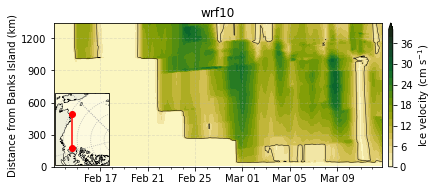

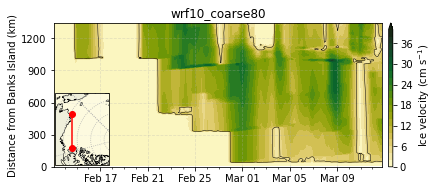

In [27]:
for i, fl in enumerate(files):

    print("loading", fl)
    ds = xr.open_dataset(fl) # load data

    # calculate ice velocity 
    ds['icevel'] = (ds['siu']**2 + ds['siv']**2)**0.5
    ds['icevel'] = ds['icevel']*100 # convert to cm/s
    ds['icevel']["units"] = "cm s$^{-1}$"

    fig, ax = plt.subplots(1,1,figsize=(6,2.5)) 
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.12, right=0.88, wspace=0.15, hspace=0.28)

    yvals, vtimes, transect = get_transect(ds['icevel'] ,start_time, end_time, xpoint, ypoint);

    plot_transect(ax, 'icevel', outdir, fl, add_insetmap=True);

    ax.set_ylabel(('Distance from Banks Island (km)'))
    ax.yaxis.set_ticks(np.arange(yvals[0], yvals[-1], step=300))  # Set label locations.
    ax.grid(linestyle='--', alpha=0.3)
    ax.set_title(expts_names[i])

    # save figure
    figname = os.path.join(outdir,
          '%s_%s-%s_%s' % ('icevel_transect_beaufort', vtimes[0].strftime('%Y%m%d'), vtimes[-1].strftime('%Y%m%d'),expts_names[i]))
    figname = figname + '.png'
    os.makedirs(os.path.dirname(figname), exist_ok=True)
    print(f'Saving {figname}')
    fig.savefig(figname, dpi=300, bbox_inches='tight')


## Plot maximum winds along transect in Beaufort Sea

opening /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
opening /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_smoothed80/outputs/Moorings.nc
Saving /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/maxwinds_transect_beaufort_20130213-20130312_wrf10_coarse80.png


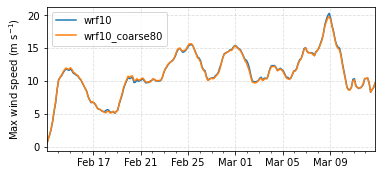

In [35]:
# create mask
x0=0; x1=260; y0=150; y1=410
mask_ocean = 1 * np.ones((ds.dims['y'], ds.dims['x'])) * np.isfinite(ds.sic.isel(time=0))  
mask_land = np.zeros((ds.dims['y'], ds.dims['x'])) * np.isnan(ds.sic.isel(time=0))  
mask_array = mask_ocean + mask_land
mask = mask_array.where((mask_array.x >= x0) & (mask_array.x <= x1) 
                         & (mask_array.y >= y0) & (mask_array.y <= y1))

fig, ax = plt.subplots(1,1,figsize=(6,2.5)) 
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.12, right=0.88, wspace=0.15, hspace=0.28)

for i, file in enumerate(files):
    
    print("opening", file)
    ds = xr.open_dataset(file)
    
    yvals, vtimes, WStrans = get_transect(ds['wspeed'], start_time, end_time, xpoint, ypoint);
    
    wspeed_avg = ds['wspeed'].where(mask==1).mean(dim=('x', 'y')) # meran in Beaufort Sea
   # wspeed_avg = WStrans.mean(dim=('y')) # mean along transect
    wspeed_max = WStrans.max(dim=('y')) # max along transect
    wspeed_med = WStrans.median(dim=('y')) # median along transect
    
    color = next(ax._get_lines.prop_cycler)['color']
    l = ax.plot(vtimes, wspeed_max, label=expts_names[i], color=color)

ax.legend(loc=2)    
days = mdates.DayLocator()  # every day
dtFmt = mdates.DateFormatter('%b %d') # define the formatting     
ax.xaxis.set_major_formatter(dtFmt)
ax.xaxis.set_minor_locator(days)
ax.set_ylabel('Max wind speed (m s$^{-1}$)')
ax.grid(linestyle='--', alpha=0.4)
ax.set_xlim(vtimes[0], vtimes[-1])

# save figure
figname = os.path.join(outdir,
      '%s_%s-%s_%s' % ('maxwinds_transect_beaufort', vtimes[0].strftime('%Y%m%d'), vtimes[-1].strftime('%Y%m%d'),expts_names[1]))
figname = figname + '.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
print(f'Saving {figname}')
fig.savefig(figname, dpi=300, bbox_inches='tight')



## Plot maps of wind speed on Feb-25

loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_wrf10/outputs/Moorings.nc
Extracting wspeed for 2013-02-25
loading /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/data/nextsim-output/breakup2013/start_20130213_nudging/expt_01_smoothed80/outputs/Moorings.nc
Extracting wspeed for 2013-02-25
Saving /home/rheinlender/shared-simstore-ns9829k/home/rheinlender/figs/breakup-paper/wspeed_maps_beaufort_2013-02-25_wrf10_coarse80.png


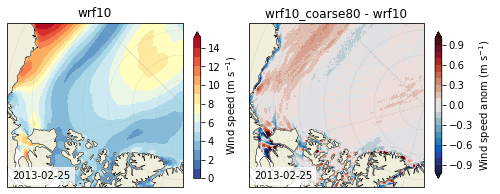

In [33]:
# Plot maps of wind speed 

vname = ['wspeed']
grid = prepare_grid(ds)

# subset variable
date = dt.datetime(2013,2,25)
dto = dt.datetime.strftime(date,'%Y-%m-%d')
    
clim = [0,15,1] # for wind speed

cmap = 'RdYlBu_r'
cb_extend = 'max'
clabel = ['Wind speed (m s$^{-1}$)', 'Wind speed anom (m s$^{-1}$)']
title_names = ['wrf10', 'wrf10_coarse80 - wrf10']
clevs = np.arange(clim[0], clim[1]+clim[2], clim[2])

fig, gs = make_figure(8,4, 1, 2); # make the figure

for i, fl in enumerate(files):

    print("loading", fl)
    ds = xr.open_dataset(fl) # load data

    # prepare axes
    ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])
    ax.add_feature(cartopy.feature.LAND, zorder=1, alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2, linewidth=0.5, alpha=0.5, linestyle="--")

    # add date inside subplots
    ax.text(0.03,0.05, dto, horizontalalignment='left',
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))

    # add title
    ax.set_title(title_names[i])
    
    for var in vname:
        print("Extracting", var, "for", dto) 
        arr = ds[var].sel(time=dto)
        arr = arr.mean(dim='time',skipna=False) # create daily fields (from 3h averages)

        if i==0:
            wrf10 = arr
            cs = ax.contourf(arr, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                        levels=clevs, cmap=cmap, extend=cb_extend)
        else:
            # anomalies
            anom = arr-wrf10
            cs = ax.contourf(anom, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                        levels=np.arange(-1, 1+0.1, 0.1), cmap= cmocean.cm.balance, extend='both')
        
        #cb_ax = fig.add_axes([0.91, 0.13, 0.01, 0.8]) # add axes for colorbar
        cbar = fig.colorbar(cs, ax=ax, label=clabel[i], shrink=0.6)    
        #fig.colorbar(cs, ax=ax, label=clabel)

# add colorbar
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.9, wspace=0.1, hspace=0.01)
#cb_ax = fig.add_axes([0.91, 0.13, 0.01, 0.8]) # add axes for colorbar
#cbar = fig.colorbar(cs, cax=cb_ax, label=clabel)     
# save figure
figname = os.path.join(outdir,
      '%s_%s_%s' % ('wspeed_maps_beaufort', dto, expts_names[1]))
figname = figname + '.png'
os.makedirs(os.path.dirname(figname), exist_ok=True)
print(f'Saving {figname}')
fig.savefig(figname, dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


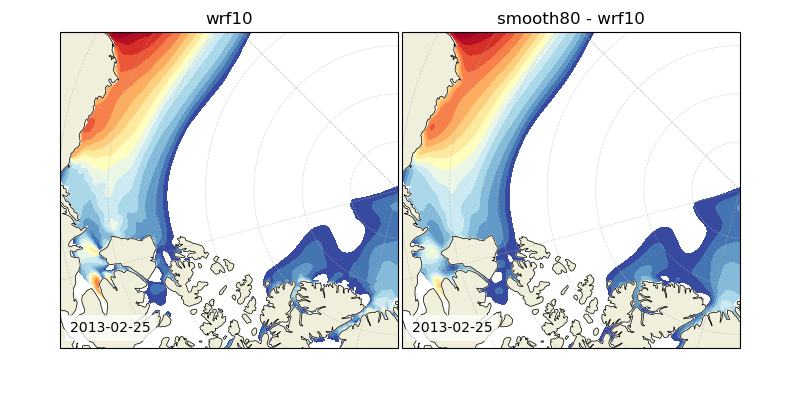

loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/expt_01_wrf10/outputs-v11/Moorings.nc
Extracting wndy for 2013-02-25
loading /cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging_smoothed/expt_01_smoothed80/outputs/Moorings.nc
Extracting wndy for 2013-02-25


In [36]:

vname=['wndy']
fig, gs = make_figure(8,4, 1, 2); # make the figure

for i, fl in enumerate(files):

    print("loading", fl)
    ds = xr.open_dataset(fl) # load data
    grid = prepare_grid(ds)
    # prepare axes
    ax = plt.subplot(gs[i], projection=grid['proj'].crs, extent=grid['extent'])
    ax.add_feature(cartopy.feature.LAND, zorder=1, alpha=1)
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2, linewidth=0.5, alpha=0.5, linestyle="--")

    # add date inside subplots
    ax.text(0.03,0.05, dto, horizontalalignment='left',
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))

    # add title
    ax.set_title(title_names[i])
    
    for var in vname:
        print("Extracting", var, "for", dto) 
        arr = ds[var].sel(time=dto)
        #arr = arr.mean(dim='time',skipna=False) # create daily fields (from 3h averages)

        cs = ax.contourf(arr[0], zorder=1, extent=[*grid['x_extent'], *grid['y_extent']], 
                   levels=clevs, cmap=cmap, extend=cb_extend)
